In [1]:
import pandas as pd
from pandas import read_csv
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import glob
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
def rmsle(y, y_pred):     
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
def rmsle_loss(y_pred, y_true):
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def lstm_multivariate(filename):
    random.seed(1)
    values = filename.values
    
    # integer encode direction
    encoder = LabelEncoder()
    values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[10,11,11,12,13,14,15,16,17]], axis=1, inplace=True)
    print(reframed.head())
    
    
    # split into train and test sets
    print("Splitting into train and test")
    values = reframed.values
    n_train_hours = 33600
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    
    # design network
    print("Designing network")
    model = Sequential()
    model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss=rmsle_loss, optimizer='adam', metrics = [rmsle_loss])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
   
    # fit network
    print("Fitting network")
    history = model.fit(train_X, train_y, epochs=15, batch_size=70,validation_split=0.04, verbose=1, shuffle=False, callbacks = [es])
    
    
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    #Metrics
    print('Calculating metrics')
    rmsle_i = rmsle(inv_y, inv_yhat)
    
    return rmsle_i


filename number 1 of 22
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065983   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068225   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.067585   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.115631   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.065022   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068225  
2   0.403581   0.909091        1.0  0.067585  
3   0.414601   0.870130        1.0  0.115631  
4   0.414601   0.870130        1.0  0.065022  
5   0.362948   0.883117        1.0  0.059898  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 8s 263us/step - loss: 0.0706 - rmsle_loss: 0.0706 - 

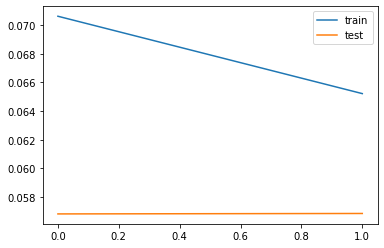

Calculating metrics
filename number 2 of 22
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025372   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027303   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.059846   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030061   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006343   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027303  
2   0.403581   0.909091        1.0  0.059846  
3   0.414601   0.870130        1.0  0.030061  
4   0.414601   0.870130        1.0  0.006343  
5   0.362948   0.883117        1.0  0.006343  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
 1120/32256 [>.............................] - ETA: 43s - loss: 0.1174 - rmsle_

/Users/mariabelenalberti/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101187). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


32256/32256 [==============================] - 8s 233us/step - loss: 0.0868 - rmsle_loss: 0.0868 - val_loss: 0.0920 - val_rmsle_loss: 0.0953
Epoch 2/15
32256/32256 [==============================] - 4s 117us/step - loss: 0.0818 - rmsle_loss: 0.0818 - val_loss: 0.0917 - val_rmsle_loss: 0.0949
Epoch 3/15
32256/32256 [==============================] - 4s 131us/step - loss: 0.0813 - rmsle_loss: 0.0813 - val_loss: 0.0901 - val_rmsle_loss: 0.0933
Epoch 4/15
32256/32256 [==============================] - 4s 132us/step - loss: 0.0810 - rmsle_loss: 0.0810 - val_loss: 0.0881 - val_rmsle_loss: 0.0912
Epoch 5/15
32256/32256 [==============================] - 4s 117us/step - loss: 0.0807 - rmsle_loss: 0.0807 - val_loss: 0.0868 - val_rmsle_loss: 0.0897
Epoch 6/15
32256/32256 [==============================] - 6s 185us/step - loss: 0.0804 - rmsle_loss: 0.0804 - val_loss: 0.0862 - val_rmsle_loss: 0.0890
Epoch 7/15
32256/32256 [==============================] - 9s 276us/step - loss: 0.0801 - rmsle_loss

KeyboardInterrupt: 

In [6]:
# load the dataset
path = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/code_datasets/1_data_frames/multivariate/affluent_tou"
all_files = glob.glob(path + "/*.csv")

i = 0
rmsle_t = []
for filename in all_files:
    i = i + 1
    print('filename number ' + str(i) + ' of ' + str(len(all_files)))
    df = pd.read_csv(filename,parse_dates = ['tstp'], index_col = ['tstp'])
    rmsle_i = lstm_multivariate(df)
    rmsle_t.append(round(rmsle_i,3))

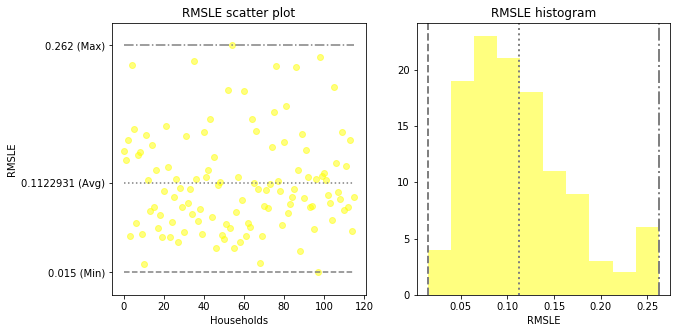

In [155]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(range(len(rmsle_t)),rmsle_t,color = 'yellow',alpha = 0.5)
plt.plot(range(len(rmsle_t)),[min(rmsle_t)]*len(rmsle_t),color = 'grey',linestyle = '--')
plt.plot(range(len(rmsle_t)),[round(np.average(rmsle_t),7)]*len(rmsle_t),color = 'grey',linestyle = ':')
plt.plot(range(len(rmsle_t)),[max(rmsle_t)]*len(rmsle_t),color = 'grey',linestyle = '-.')
plt.yticks([min(rmsle_t),round(np.average(rmsle_t),7),max(rmsle_t)],[str(min(rmsle_t)) + ' (Min)',
                                                            str(round(np.average(rmsle_t),7)) + ' (Avg)',
                                                                         str(max(rmsle_t))+' (Max)'])
plt.title('RMSLE scatter plot',fontsize = 12)
plt.xlabel('Households')
plt.ylabel('RMSLE')

plt.subplot(122)
plt.hist(rmsle_t,color = 'yellow',alpha = 0.5)
plt.axvline(x=min(rmsle_t), color='grey', linestyle='--', linewidth=2)
plt.axvline(x=round(np.average(rmsle_t),7), color='grey', linestyle=':', linewidth=2)
plt.axvline(x=max(rmsle_t), color='grey', linestyle='-.', linewidth=2)

plt.title("RMSLE histogram",fontsize = 12)
plt.xlabel('RMSLE')
plt.savefig('/Users/mariabelenalberti/Desktop/150_aff_std')

plt.show();

In [143]:
print(rmsle_t)

[0.077]
